In [1]:
from training_rl.offline_rl.custom_envs.custom_envs_registration import register_grid_envs
import warnings
from training_rl.offline_rl.load_env_variables import load_env_variables
from training_rl.offline_rl.custom_envs.utils import Grid2DInitialConfig
from training_rl.offline_rl.custom_envs.custom_2d_grid_env.obstacles_2D_grid_register import ObstacleTypes
from training_rl.offline_rl.offline_policies.policy_registry import PolicyName
from training_rl.offline_rl.behavior_policies.behavior_policy_registry import BehaviorPolicyType
from training_rl.offline_rl.custom_envs.custom_envs_registration import CustomEnv
from training_rl.offline_rl.custom_envs.custom_envs_registration import RenderMode
from training_rl.offline_rl.offline_policies.offpolicy_rendering import offpolicy_rendering
from training_rl.offline_rl.generate_custom_minari_datasets.utils import generate_compatible_minari_dataset_name
import minari
from training_rl.offline_rl.generate_custom_minari_datasets.utils import get_dataset_name_2d_grid
from training_rl.offline_rl.generate_custom_minari_datasets.generate_minari_dataset_grid_envs import \
    MinariDatasetConfig, create_minari_datasets
from training_rl.offline_rl.scripts.visualizations.utils import get_state_action_data_and_policy_grid_distributions, \
    snapshot_env
from training_rl.offline_rl.custom_envs.utils import InitialConfigCustom2DGridEnvWrapper
from training_rl.offline_rl.utils import load_buffer_minari, state_action_histogram
from training_rl.offline_rl.offline_trainings.policy_config_data_class import TrainedPolicyConfig
from training_rl.offline_rl.offline_trainings.offline_training import offline_training
from training_rl.offline_rl.utils import compare_state_action_histograms
import torch
import os
from training_rl.offline_rl.offline_trainings.policy_config_data_class import get_trained_policy_path
from training_rl.offline_rl.offline_trainings.restore_policy_model import restore_trained_offline_policy
from copy import copy
import gymnasium as gym


load_env_variables()
warnings.filterwarnings("ignore")
# ToDo: this should be load automatically
register_grid_envs()


/home/ivan/anaconda3/envs/tianshou_dev/lib/python3.8/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/ivan/anaconda3/envs/tianshou_dev/lib/python3.8/site-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/home/ivan/anaconda3/envs/tianshou_dev/lib/python3.8/site-packages/pkg_resources/__init__.py:2350: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`

**In this exercise, we will work with a simple example of BC. The goal is to explore some of the issues with imitation learning and become familiar with the Tianshou library for offline RL training!**

In the code below, we will create a Minari dataset, as we did previously, but this time we will use the function **create_minari_datasets(...)** which saves some useful metadata. This metadata is important for recreating the environment associated with the data when testing our trained policy.

We will also utilize one of our registered behavioral policies, but let's first take a look at it.

In [3]:
ENV_NAME = CustomEnv.Grid_2D_8x8_discrete
BEHAVIOR_POLICY = BehaviorPolicyType.behavior_8x8_random_towards_left_within_strip
OFFLINE_POLICY = PolicyName.imitation_learning

# Two dimensional grid world data
OBSTACLE = ObstacleTypes.obst_big_8x8
INITIAL_STATE = (0, 0)
FINAL_STATE = (0, 7)

env_2D_grid_initial_config = Grid2DInitialConfig(
    obstacles=OBSTACLE,
    initial_state=INITIAL_STATE,
    target_state=FINAL_STATE,
)

In [4]:
offpolicy_rendering(
    env_or_env_name=ENV_NAME,
    render_mode=RenderMode.RGB_ARRAY_LIST,
    behavior_policy_name=BEHAVIOR_POLICY,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=1000,
)

QObject::moveToThread: Current thread (0x56012ed2e9a0) is not the object's thread (0x56012f1e2c20).
Cannot move to target thread (0x56012ed2e9a0)

QObject::moveToThread: Current thread (0x56012ed2e9a0) is not the object's thread (0x56012f1e2c20).
Cannot move to target thread (0x56012ed2e9a0)

QObject::moveToThread: Current thread (0x56012ed2e9a0) is not the object's thread (0x56012f1e2c20).
Cannot move to target thread (0x56012ed2e9a0)

QObject::moveToThread: Current thread (0x56012ed2e9a0) is not the object's thread (0x56012f1e2c20).
Cannot move to target thread (0x56012ed2e9a0)

QObject::moveToThread: Current thread (0x56012ed2e9a0) is not the object's thread (0x56012f1e2c20).
Cannot move to target thread (0x56012ed2e9a0)

QObject::moveToThread: Current thread (0x56012ed2e9a0) is not the object's thread (0x56012f1e2c20).
Cannot move to target thread (0x56012ed2e9a0)

QObject::moveToThread: Current thread (0x56012ed2e9a0) is not the object's thread (0x56012f1e2c20).
Cannot move to tar

InterruptedError: You quit ('q') the animation.

**Note that the policy is not random; it includes expert information, as it has a bias to reach the target**. This is, of course, the preferred situation in realistic problems as well and the perfect situation to apply Behavioral Cloning (BC).

Let's configure our Minari dataset. 

In [6]:
DATA_SET_NAME = "data"
DATA_SET_IDENTIFIER = "_exercise_5"
VERSION_DATA_SET = "v0"
NUM_STEPS = 10000


# Minari has its own convention for dataset naming
name_expert_data = generate_compatible_minari_dataset_name(ENV_NAME, DATA_SET_NAME, VERSION_DATA_SET)

DATA_SET_NAME += DATA_SET_IDENTIFIER
DATASET_CONFIG = {"env_name": ENV_NAME, "data_set_name": name_expert_data, "num_steps": NUM_STEPS,
                  "behavior_policy": BEHAVIOR_POLICY, "initial_config_2d_grid_env": env_2D_grid_initial_config}

# Grid world env. config
DATA_SET_NAME = get_dataset_name_2d_grid(env_2D_grid_initial_config) + DATA_SET_IDENTIFIER
name_expert_data = generate_compatible_minari_dataset_name(ENV_NAME, DATA_SET_NAME, VERSION_DATA_SET)
DATASET_CONFIG["data_set_name"] = name_expert_data

# MinariDatasetConfig will take care of dataset configuration (serialized, deserialize, from_dict, etc.)
minari_dataset_config = MinariDatasetConfig.from_dict(DATASET_CONFIG)
create_minari_datasets(minari_dataset_config)

data = minari.load_dataset(DATASET_CONFIG["data_set_name"])
print("number of episodes collected: ", len(data))
#for elem in data:
#    print(elem.actions, elem.truncations, elem.terminations)


number of episodes collected:  246


Let's take a look at the state-action data distribution. Since we are going to use the Tianshou RL library, we will load the previous dataset into a Tianshou ReplayBuffer object.

Dataset /home/ivan/Documents/GIT_PROJECTS/Tianshou/tianshou/examples/offline_RL_workshop/data/offline_data/Grid_2D_8x8_discrete-data_obst_big_8x8_start_0_0_target_0_7_exercise_5-v0 downloaded. number of episodes: 246


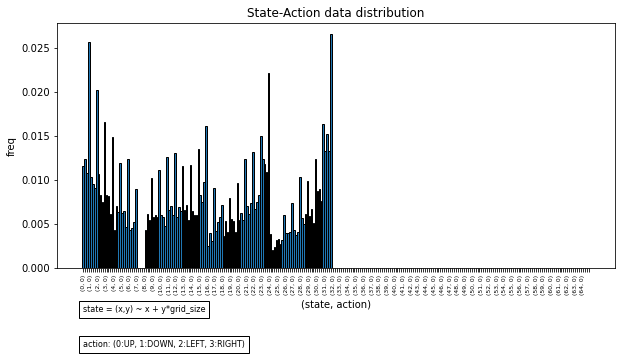

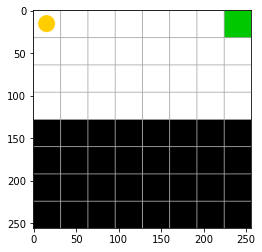

In [7]:
# Data saved in /offline_data
NAME_EXPERT_DATA = "Grid_2D_8x8_discrete-data_obst_big_8x8_start_0_0_target_0_7_exercise_5-v0" 

# fill the ReplyBuffer
buffer_data = load_buffer_minari(NAME_EXPERT_DATA)

# We will need the env for the plots. 
data_config = MinariDatasetConfig.load_from_file(NAME_EXPERT_DATA)
env_config = data_config.initial_config_2d_grid_env
render_mode = RenderMode.RGB_ARRAY_LIST
env = InitialConfigCustom2DGridEnvWrapper(gym.make(ENV_NAME, render_mode=render_mode), env_config=env_config)

# Compute state-action data distribution
state_action_count_data, _ = get_state_action_data_and_policy_grid_distributions(buffer_data, env)
state_action_histogram(state_action_count_data, title="State-Action data distribution", inset_pos_xy=(-0.1, -0.005))

snapshot_env(env)

The state-action distribution makes sense! The agent starts at (0,0), and since the episode length is finite (200 steps), the ball will more likely be around the upper-left corner.

### Let's train our first offline RL algorithm: Imitation Learning.

Before we proceed, let's take a moment to become a little more familiar with the code. Let's spend some minutes reviewing:

    a - il_policy.py
    b - policy_registry.py 
    c - training.py
    

In [ ]:
NAME_EXPERT_DATA = "Grid_2D_8x8_discrete-data_obst_big_8x8_start_0_0_target_0_7_exercise_5-v0"

# The model policy to be trained.
POLICY_NAME = PolicyName.imitation_learning

NUM_EPOCHS = 300
BATCH_SIZE = 256
UPDATE_PER_EPOCH = 100

# After every epoch we will collect some test statistics from the policy from NUMBER_TEST_ENVS independent envs.
NUMBER_TEST_ENVS = 1
EXPLORATION_NOISE = True
SEED = None #1626

# TrainedPolicyConfig is a handy object that will help us to deal with the policy configuration data.
offline_policy_config = TrainedPolicyConfig(
    name_expert_data=NAME_EXPERT_DATA,
    policy_name=POLICY_NAME,
    render_mode=RenderMode.RGB_ARRAY_LIST,
    device="cpu"
)

# Run the training
offline_training(
    offline_policy_config=offline_policy_config,
    num_epochs = NUM_EPOCHS,
    number_test_envs=NUMBER_TEST_ENVS,
    update_per_epoch=UPDATE_PER_EPOCH,
    restore_training=False,
)

Let's take a look at the state-action BC policy distribution.

4 64


Processing: 100%|█████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


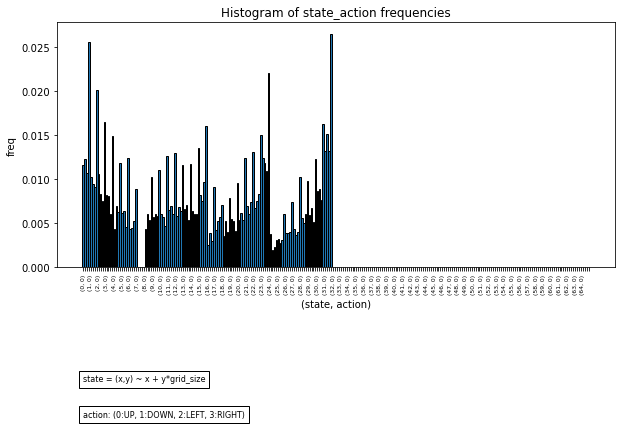

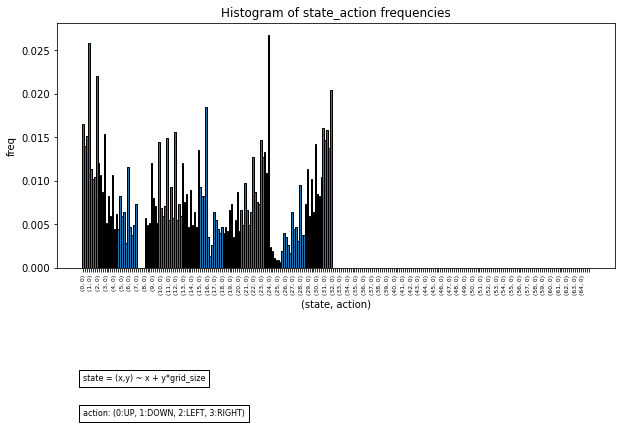

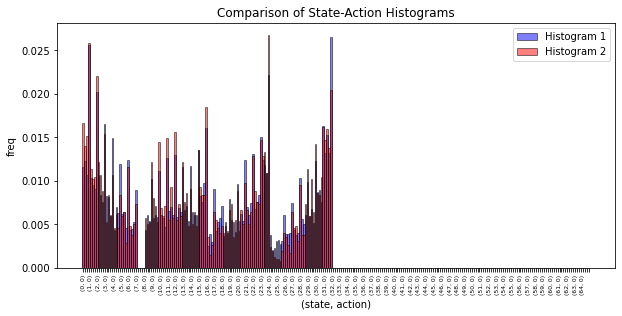

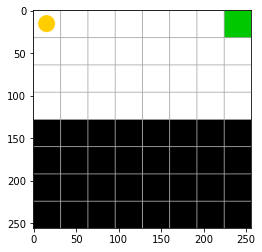

In [9]:
POLICY_FILE = "policy_final.pth"
NUM_EPISODES = 100 # as more episodes the better

# restore a policy with the same configuration as the one we trained.
policy = restore_trained_offline_policy(offline_policy_config)
# load the weights
name_expert_data = offline_policy_config.name_expert_data
log_name = os.path.join(name_expert_data, POLICY_NAME)
log_path = get_trained_policy_path(log_name)
policy.load_state_dict(torch.load(os.path.join(log_path, POLICY_FILE), map_location="cpu"))

# compute statistics
state_action_count_data, state_action_count_policy = \
    get_state_action_data_and_policy_grid_distributions(
    buffer_data, 
    env, 
    policy, 
    num_episodes=NUM_EPISODES,
    logits_sampling=True,
)

# plots
state_action_histogram(state_action_count_data, title="State-Action data distribution")
state_action_histogram(state_action_count_policy, title="State-Action policy distribution")
compare_state_action_histograms(state_action_count_data, state_action_count_policy)
snapshot_env(env)

As expected, the learned policy has a very similar distribution to the dataset, so they will perform similarly!

Let's now visualize the policy by sampling from the policy distribution (imitation_policy_sampling=True) and by taking $\arg \max_a \pi(s|a)$ (imitation_policy_sampling=False)

In [10]:
offpolicy_rendering(
    env_or_env_name=env,
    render_mode=RenderMode.RGB_ARRAY_LIST,
    policy_model=policy,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=1000,
    imitation_policy_sampling=False
)

#final_collector = Collector(policy, env, exploration_noise=EXPLORATION_NOISE)
#final_collector.collect(n_episode=20, render=1 / 35)

QObject::moveToThread: Current thread (0x56012ed2e9a0) is not the object's thread (0x56012f1e2c20).
Cannot move to target thread (0x56012ed2e9a0)

QObject::moveToThread: Current thread (0x56012ed2e9a0) is not the object's thread (0x56012f1e2c20).
Cannot move to target thread (0x56012ed2e9a0)

QObject::moveToThread: Current thread (0x56012ed2e9a0) is not the object's thread (0x56012f1e2c20).
Cannot move to target thread (0x56012ed2e9a0)

QObject::moveToThread: Current thread (0x56012ed2e9a0) is not the object's thread (0x56012f1e2c20).
Cannot move to target thread (0x56012ed2e9a0)

QObject::moveToThread: Current thread (0x56012ed2e9a0) is not the object's thread (0x56012f1e2c20).
Cannot move to target thread (0x56012ed2e9a0)

QObject::moveToThread: Current thread (0x56012ed2e9a0) is not the object's thread (0x56012f1e2c20).
Cannot move to target thread (0x56012ed2e9a0)

QObject::moveToThread: Current thread (0x56012ed2e9a0) is not the object's thread (0x56012f1e2c20).
Cannot move to tar

KeyboardInterrupt: 

**As our dataset includes a fair amount of expert data, by taking the $\arg \max_a \pi(s|a)$, we are able to remove the noise from the data and obtain the expert policy! This is a nice property of imitation learning!**

However, note that in real life, the forbidden zone (black region) in the environment could be a playground or a garden, and there could be a good reason not to go there. So let's use our trained agent and see what happens when we remove the restriction.

### EXERCISE 1:

Remove the obstacle and examine the state-action distribution. What do you observe? Can you explain it?

Hint: You can create a copy of the previous environment and use ObstacleTypes.obst_free_8x8 in your configuration, like this:

    new_env_config = copy(env_config)
    new_env_config.obstacles = ObstacleTypes.obst_free_8x8
    env = InitialConfigCustom2DGridEnvWrapper(gym.make(ENV_NAME, render_mode=render_mode), 
    env_config=new_env_config)

### SOLUTION

Processing: 100%|█████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


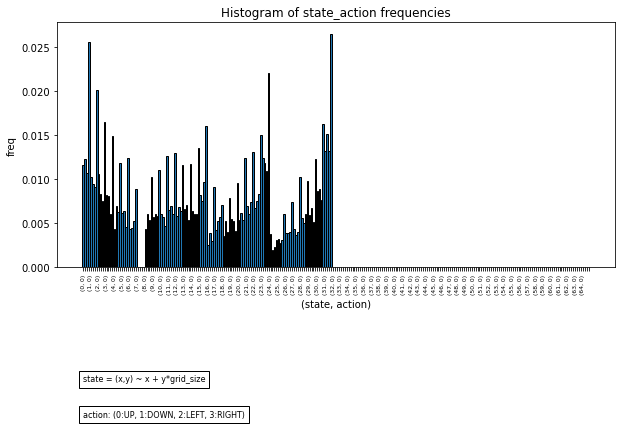

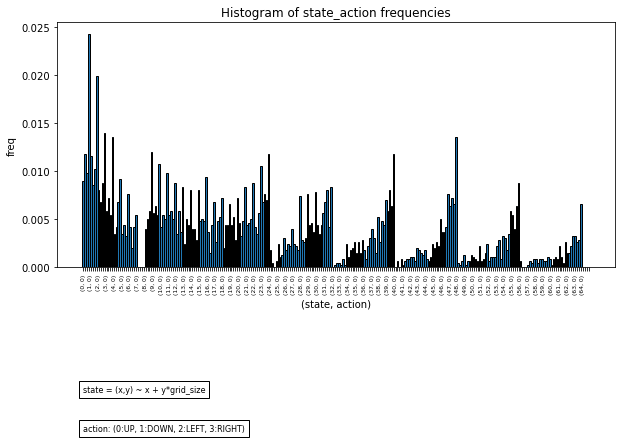

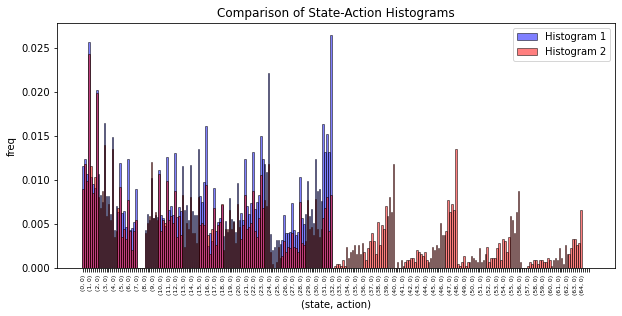

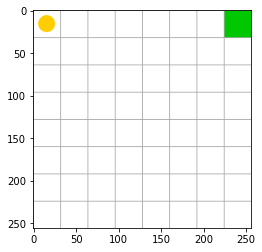

In [11]:
# Let's now remove the forbiden region and recreate the environment
new_env_config = copy(env_config)
new_env_config.obstacles = ObstacleTypes.obst_free_8x8
env = InitialConfigCustom2DGridEnvWrapper(gym.make(ENV_NAME, render_mode=render_mode), env_config=new_env_config)

state_action_count_data, state_action_count_policy = \
    get_state_action_data_and_policy_grid_distributions(
    buffer_data, 
    env, 
    policy, 
    num_episodes=NUM_EPISODES,
    logits_sampling=True,
)
state_action_histogram(state_action_count_data, title="State-Action data distribution")

state_action_histogram(state_action_count_policy, title="State-Action policy distribution")
compare_state_action_histograms(state_action_count_data, state_action_count_policy)

snapshot_env(env)

**DISTRIBUTIONAL SHIFT EFFECT**: As we can see, there is a distributional shift effect in this case, mainly due to out-of-distribution state-action pairs as the agent attempts to move into unexplored regions. This is an undesired effect caused by function approximation, i.e., the DNN policy cannot perfectly capture the state-action distribution in regions where there is little or no data. This effect is highly undesirable and should be eliminated. When close to unexplored regions, the policy will behave unpredictably.

Let's start from a forbbiden position to see what happens.

In [12]:
new_env_config = copy(env_config)
new_env_config.obstacles = ObstacleTypes.obst_free_8x8
new_env_config.initial_state = (4,0)
env = InitialConfigCustom2DGridEnvWrapper(gym.make(ENV_NAME, render_mode=render_mode), env_config=new_env_config)


offpolicy_rendering(
    env_or_env_name=env,
    render_mode=RenderMode.RGB_ARRAY_LIST,
    policy_model=policy,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=1000,
    imitation_policy_sampling=False
)

InterruptedError: You quit ('q') the animation.

As we can see, the behavior of the agent when it starts from out-of-distribution data is entirely unexpected. This is normal because the provided expert policy is only designed to guide the agent from any point within the allowed zone to the target.

In conclusion, imitation learning becomes interesting when one has access to noisy expert data, as it provides a means to reduce noise from the expert data.

Another noteworthy aspect of imitation learning is that it doesn't rely on rewards, making it a less complex solution to the problem of reward shaping in reinforcement learning.

However, in realistic applications, obtaining expert data is often a challenge. In many cases, we have access to only a limited number of trajectories, rendering this method less useful for extracting optimal policies.

This is where offline RL algorithms come into play!